In [1]:
import logging
import os
import numpy as np

import sys


def load_path():
    # Get the path of the current script's directory
    current_dir = os.path.dirname(os.path.realpath("__file__"))
    # Get the path of the parent directory
    parent_dir = os.path.dirname(current_dir)
    # Add the parent directory to sys.path
    sys.path.append(parent_dir)

load_path()


In [2]:
from config.config import config
from models.semantic_cache import SemanticCache


name: str = "semantic-cache"
storage: str = "memory"
llm: str = "redis" # local
similarity_threshold: float = 0.8
encode_model: str = "all-mpnet-base-v2"

#default_cache = SemanticCache.from_config(config)

semantic_cache1 = SemanticCache(name=name, storage=storage, llm=llm,similarity_threshold=similarity_threshold, encode_model=encode_model )


/Users/rushoislam/semantic_caching_challange/semantic_caching_challange/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:utils.utils:memory Storage set
INFO:utils.utils:all-mpnet-base-v2 Encoder_model set
INFO:utils.utils:redis LLM set
INFO:utils.utils:storage type memory with ttl 3600
INFO:utils.utils:llm type redis
INFO:utils.utils:similarity threshold 0.8


In [3]:
from utils.faq_data_container import FAQDataContainer


data_container = FAQDataContainer()
faq_df, test_df = data_container.faq_df, data_container.test_df

test_queries = test_df["question"].tolist()

Loaded 8 FAQ entries
Loaded 80 test queries


In [4]:
faq_df

,id,question,answer
0,0,How do I get a refund?,"To request a refund, visit your orders page an..."
1,1,Can I reset my password?,Click **Forgot Password** on the login page an...
2,2,Where is my order?,Use the tracking link sent to your email after...
3,3,How long is the warranty?,All electronic products include a 12-month war...
4,4,Do you ship internationally?,"Yes, we ship to over 50 countries worldwide. I..."
5,5,How do I cancel my subscription?,Go to Account Settings > Subscriptions and cli...
6,6,What payment methods do you accept?,"We accept all major credit cards, PayPal, Appl..."
7,7,Can I change my delivery address?,You can update your delivery address before yo...


In [5]:
semantic_cache1.ingest_from_df(faq_df)

Batches: 100%|██████████| 1/1 [00:00<00:00, 46.42it/s]


In [6]:
semantic_cache1.check(faq_df["question"].iloc[0], False)

INFO:utils.utils:forceRefresh false
Batches: 100%|██████████| 1/1 [00:00<00:00, 50.16it/s]


[{'response': 'To request a refund, visit your orders page and select **Request Refund**. Refunds are processed within 3-5 business days.',
  'meta_data': {'source': 'cache',
   'vector_similarity': 1.0000000141077952,
   'prompt': 'How do I get a refund?',
   'latency': 0.0002702919882722199}}]

In [7]:
res = semantic_cache1.check("Whats the refund policy?", False)

INFO:utils.utils:forceRefresh false
Batches: 100%|██████████| 1/1 [00:00<00:00, 41.96it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 69.76it/s]


In [8]:
res[0].get('meta_data').get('source')

'llm'

In [9]:
res[0].get('meta_data').get('latency')

17.961606666009175

In [10]:

from utils.eval_utils import PerfEval


perf_eval = PerfEval()

test_questions = [
    "whats the capital of Bangladesh?",
    "How can I get my money back?",
    "I want a refund please",
    "What's your return policy?",
    "I forgot my password",
    "Can you help me reset my password?",
    "What are your shipping costs?",
    "Do you offer installation services?",
    "Can I schedule a phone call with support?",
    "How do I cancel my subscription?",
    "How much does shipping cost?",
    "I need to cancel my account",
    "Whats the national sport of Canada"
]

perf_eval.set_total_queries(len(test_questions))

In [11]:
with perf_eval:
    for i, question in enumerate(test_questions, 1):
        print(f"\n[{i}] Question: '{question}'")

        cached_result = semantic_cache1.check(question, False)
        cache_type = cached_result[0].get('meta_data').get('source')
        vector_similarity = cached_result[0].get('meta_data').get('vector_similarity')  
        response = cached_result[0].get('response')
        latency = cached_result[0].get('meta_data').get('latency')
        
        if  cache_type == 'cache':
            # Cache HIT
            perf_eval.tick("cache_hit", latency)
            print(
                f"    ✅ CACHE HIT (similarity: {vector_similarity:.3f})"
            )
            print(f"    📋 Cached question: {question[:80]}...")
            print(f"    📋 Cached response: {response[:80]}...")
        else:
            # Cache MISS - call LLM
            perf_eval.tick("cache_miss")  # Time for cache check
            print(f"    ❌ CACHE MISS")
            print(f"    🤖 Calling LLM... ", end="")
            # Call LLM and track the call
            perf_eval.tick("llm_call", latency)
            MODEL_NAME = 'llama3.2:1b'
            perf_eval.record_llm_call(MODEL_NAME, question, response)
            print(f"    💬 LLM response: {response[:80]}...")

INFO:utils.utils:forceRefresh false



[1] Question: 'whats the capital of Bangladesh?'


Batches: 100%|██████████| 1/1 [00:00<00:00, 37.84it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 34.83it/s]


    ❌ CACHE MISS
    🤖 Calling LLM... 

INFO:utils.utils:forceRefresh false


    💬 LLM response: The capital of Bangladesh is Dhaka....

[2] Question: 'How can I get my money back?'


Batches: 100%|██████████| 1/1 [00:00<00:00, 34.87it/s]
INFO:utils.utils:forceRefresh false


    ✅ CACHE HIT (similarity: 0.873)
    📋 Cached question: How can I get my money back?...
    📋 Cached response: To request a refund, visit your orders page and select **Request Refund**. Refun...

[3] Question: 'I want a refund please'


Batches: 100%|██████████| 1/1 [00:00<00:00, 36.48it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 59.75it/s]
INFO:utils.utils:forceRefresh false


    ❌ CACHE MISS
    🤖 Calling LLM...     💬 LLM response: If you're requesting a refund, I'll do my best to assist you. Could you please p...

[4] Question: 'What's your return policy?'


Batches: 100%|██████████| 1/1 [00:00<00:00, 56.50it/s]
INFO:utils.utils:forceRefresh false


    ✅ CACHE HIT (similarity: 0.809)
    📋 Cached question: What's your return policy?...
    📋 Cached response: Our refund policy is designed to provide you with peace of mind and protect your...

[5] Question: 'I forgot my password'


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 67.19it/s]
INFO:utils.utils:forceRefresh false


    ❌ CACHE MISS
    🤖 Calling LLM...     💬 LLM response: Forgetting a password can be frustrating. Here are some steps you can try to rec...

[6] Question: 'Can you help me reset my password?'


Batches: 100%|██████████| 1/1 [00:00<00:00, 48.46it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 69.30it/s]
INFO:utils.utils:forceRefresh false


    ❌ CACHE MISS
    🤖 Calling LLM...     💬 LLM response: I can guide you through the process. If you're having trouble resetting your pas...

[7] Question: 'What are your shipping costs?'


Batches: 100%|██████████| 1/1 [00:00<00:00, 50.33it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 70.79it/s]
INFO:utils.utils:forceRefresh false


    ❌ CACHE MISS
    🤖 Calling LLM...     💬 LLM response: As a text-based AI assistant, I don't have any shipping costs associated with my...

[8] Question: 'Do you offer installation services?'


Batches: 100%|██████████| 1/1 [00:00<00:00, 71.35it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 67.83it/s]
INFO:utils.utils:forceRefresh false


    ❌ CACHE MISS
    🤖 Calling LLM...     💬 LLM response: I'm a large language model, I don't have a physical presence or direct access to...

[9] Question: 'Can I schedule a phone call with support?'


Batches: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 60.01it/s]
INFO:utils.utils:forceRefresh false


    ❌ CACHE MISS
    🤖 Calling LLM...     💬 LLM response: You can contact our support team through various channels. We're available to he...

[10] Question: 'How do I cancel my subscription?'


Batches: 100%|██████████| 1/1 [00:00<00:00, 40.10it/s]
INFO:utils.utils:forceRefresh false


    ✅ CACHE HIT (similarity: 1.000)
    📋 Cached question: How do I cancel my subscription?...
    📋 Cached response: Go to Account Settings > Subscriptions and click **Cancel Subscription**. You'll...

[11] Question: 'How much does shipping cost?'


Batches: 100%|██████████| 1/1 [00:00<00:00, 57.04it/s]
INFO:utils.utils:forceRefresh false


    ✅ CACHE HIT (similarity: 0.930)
    📋 Cached question: How much does shipping cost?...
    📋 Cached response: As a text-based AI assistant, I don't have any shipping costs associated with my...

[12] Question: 'I need to cancel my account'


Batches: 100%|██████████| 1/1 [00:00<00:00, 49.08it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 62.60it/s]
INFO:utils.utils:forceRefresh false


    ❌ CACHE MISS
    🤖 Calling LLM...     💬 LLM response: You can usually cancel your subscription or account online, by phone, or through...

[13] Question: 'Whats the national sport of Canada'


Batches: 100%|██████████| 1/1 [00:00<00:00, 65.55it/s]
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 47.08it/s]

    ❌ CACHE MISS
    🤖 Calling LLM...     💬 LLM response: The national sport of Canada is ice hockey. It has been an integral part of Cana...


In [12]:
import numpy as np
mean_cache_latency = np.mean(perf_eval.durations_by_label['cache_hit'])
print(f'Avg latency for cache hits {mean_cache_latency:.6f} secs')

Avg latency for cache hits 0.000183 secs


In [13]:
mean_llm_latency = np.mean(perf_eval.durations_by_label['llm_call'])
print(f'Avg latency for LLM calls {mean_llm_latency:.6f} secs')

Avg latency for LLM calls 9.997814 secs


In [14]:
metrics = perf_eval.get_metrics(labels=["cache_hit", "llm_call"])

In [15]:
metrics

{'overall': {'count': 22,
  'average_latency': 4090.0479015888945,
  'p50': 0.18191698472946882,
  'p90': 11547.434992293713,
  'p95': 17902.516106610703,
  'p99': 20079.408600636812,
  'average_throughput': 244.4959139993255},
 'by_label': {'cache_hit': {'count': 4,
   'average_latency': 0.1828437452786602,
   'p50': 0.18191698472946882,
   'p90': 0.19301639695186168,
   'p95': 0.1937787004862912,
   'p99': 0.19438854331383482,
   'average_throughput': 5469150.713774569},
  'llm_call': {'count': 9,
   'average_latency': 9997.81360666384,
   'p50': 9746.060125005897,
   'p90': 18701.06540020788,
   'p95': 19635.53536660038,
   'p99': 20383.111339714378,
   'average_throughput': 100.02186871472281}}}

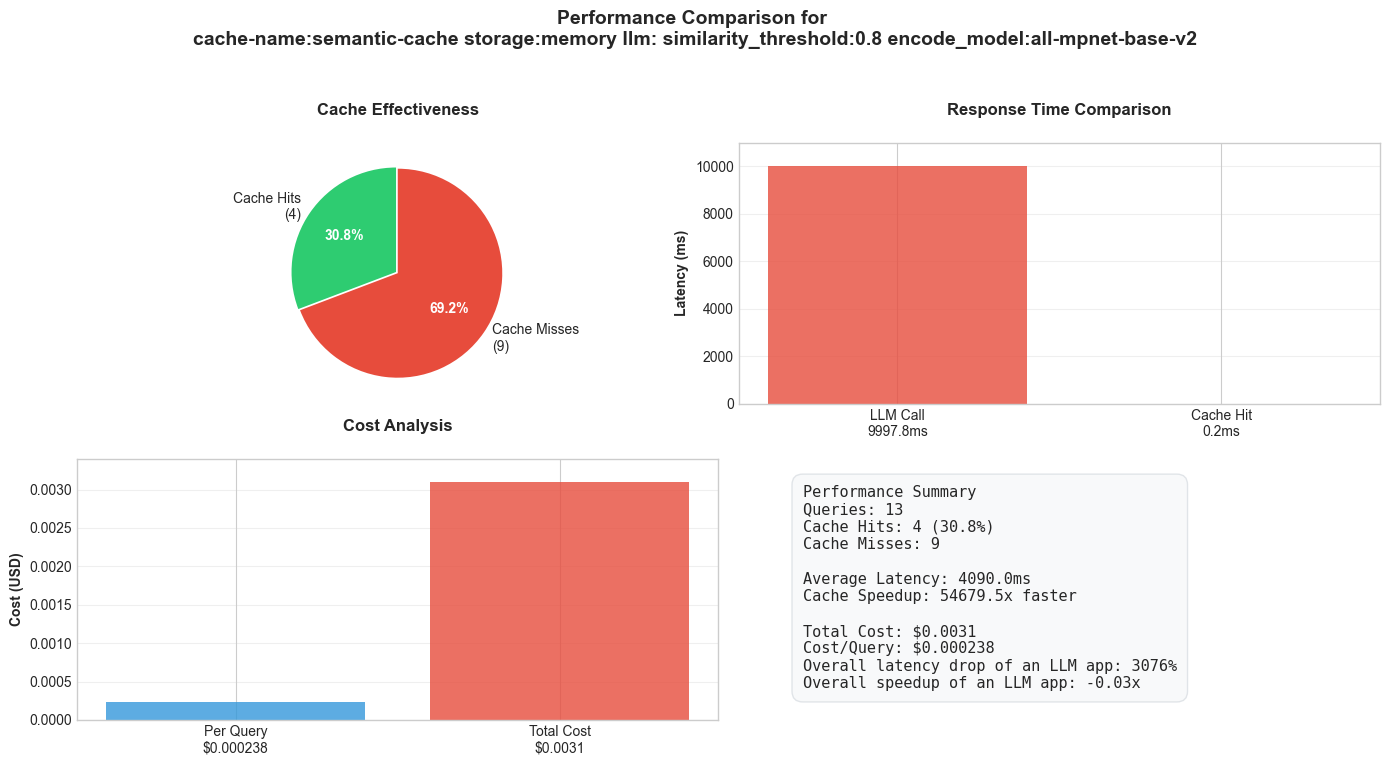

In [16]:


perf_eval.plot(
    title=f"Performance Comparison for \ncache-name:{name} storage:{storage} llm: similarity_threshold:{similarity_threshold} encode_model:{encode_model}", show_cost_analysis=True
)